In [2]:
import cv2
from mpl_toolkits.mplot3d import Axes3D
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
from math import pow , sqrt, atan2
import math
import pywt
from scipy.signal import find_peaks

from sklearn.manifold import LocallyLinearEmbedding
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(color_codes=True)

from scipy.signal import argrelextrema
from scipy.spatial.distance import pdist
from scipy.stats.mstats import pearsonr, spearmanr



Axes3D


mpl_toolkits.mplot3d.axes3d.Axes3D

# Functions

In [122]:
# Calculate the Residual variance with original dataset and LLE or HLLE dataset

def res_var(X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    #pairwise euclidean distance
    Dx = pdist(X_origi, 'euclidean')
    Dy = pdist(X_transfo, 'euclidean')

    #Pearson correlation
    pxy, _ = pearsonr(Dx, Dy)

    #residual variance
    res_var = 1 - pxy**2
    
    return res_var
# Calculate the Spearman's rho coeff with original dataset and LLE or HLLE dataset
def SpearsmansRho (X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_origi)
    dist, _ = nbrs.kneighbors(X_origi)

    nbrs2 = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_transfo)
    dist2, _ = nbrs2.kneighbors(X_transfo)

    dist  = np.delete(dist, 0, 1)
    dist2 = np.delete(dist2, 0, 1)
    coef, p = spearmanr(dist, dist2,axis=None)
    return  np.mean(coef)

# find best number of neighbor in function of the Topology
def num_neigh(Data,dim, meth,plot="ON"):
    SP_Rho_vect       = []
    Residual_var_vect = []
    N_Neigh_Max       = 35
    NCOMP             = dim
    if meth == "standard":
        nmin   = NCOMP+1
        Vect_N = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin   = round(NCOMP*(NCOMP+3)/2)+2
        Vect_N = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
    for i in Vect_N:
        DataTransfo, err = manifold.locally_linear_embedding(Data, n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
        Tot_Err.append(err)
        SP_Rho_vect.append(SpearsmansRho(Data,DataTransfo))
        Residual_var_vect.append(res_var(Data,DataTransfo))

    Tot_err = np.array(Tot_Err)
    maxval_SP =max(SP_Rho_vect[nmin:]) 
    indicemax_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP =min(SP_Rho_vect[nmin:]) 
    indicemin_SP = SP_Rho_vect.index(minval_SP)
    
    
    if plot == "ON":
        plt.figure(meth,figsize=(8, 8))
        plt.title( meth)
        plt.xlabel("Number of Neighbor")
        plt.ylabel("Values")
        plt.plot (SP_Rho_vect,color ="red",label="Spearman's Rho")
        plt.plot (Residual_var_vect,color ="yellow",label="residual variance")
        #plt.plot(combin,color ="orange",label="Spearman's Rho* residual variance")

        plt.plot (indicemax_SP,maxval_SP,"go",color ="green",label="max Spearman's Rho")
        plt.plot (indicemin_SP,minval_SP,"go",color ="red",label="min Spearman's Rho")

        plt.legend(loc ="lower left")
        plt.text(20,0,"worst K = "+ str(indicemin_SP) +" and best K = " + str(indicemax_SP))
        
    return indicemax_SP,indicemin_SP,Residual_var_vect,SP_Rho_vect

# find best number of neighbor in function of the classification
def num_neigh_ClassifR(Data,Label,dim, meth,Kmx,plot="ON"):
    SP_Rho_vect       = []
    Residual_var_vect = []
    classif_vect      = []
    N_Neigh_Max       = 35
    NCOMP             = 2


    # We split the data into train and test to evaluate the classification 
    Split = 0.3
    X_tr, X_ts, Label_tr, Label_ts = train_test_split(Data, Label, test_size=Split)

    # Here we normalize the data (Not neceesary on our case because data is black and white pixel)
    X_tr_St     = StandardScaler().fit_transform(X_tr)
    X_ts_St     = StandardScaler().fit_transform(X_ts)
    X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
    X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

    if meth == "standard":
        nmin   = NCOMP+1
        Vect_N = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin   = round(NCOMP*(NCOMP+3)/2)+2
        Vect_N = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
        classif_vect.append(0)

    for i in Vect_N:
        clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
        X_tr_transfo  = clf.fit_transform(X_tr_Norm)
        X_ts_transfo  = clf.transform(X_ts_Norm)
        kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
        classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
        Tot_Err.append(err)
        SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
        Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))

    Tot_err = np.array(Tot_Err)
    
    maxval_C =max(classif_vect[nmin:]) 
    indicemax_C = classif_vect.index(maxval_C)
    minval_C =min(classif_vect[nmin:]) 
    indicemin_C = classif_vect.index(minval_C)
    
    maxval_SP =max(SP_Rho_vect[nmin:]) 
    indicemax_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP =min(SP_Rho_vect[nmin:]) 
    indicemin_SP = SP_Rho_vect.index(minval_SP)


    if plot == "ON":
        plt.figure(meth,figsize=(8, 8))
        plt.title( meth)
        plt.xlabel("Number of Neighbor")
        plt.ylabel("Values")
        plt.plot (SP_Rho_vect,color ="blue",label="Spearman's Rho")
        plt.plot (Residual_var_vect,color ="green",label="residual variance")
        plt.plot(classif_vect,color ="orange",label="Classification rate")

        plt.plot (indicemax_C,maxval_C,"go",color ="yellow",label="max Classification rate")
        plt.plot (indicemin_C,minval_C,"go",color ="red",label="min Classification rate")

        plt.plot (indicemax_SP,maxval_SP,"go",color ="black",label="max Spearman")
        plt.plot (indicemin_SP,minval_SP,"go",color ="grey",label="min Spearman")
        
        plt.legend(loc ="lower left")
        plt.text(20,0,"worst K = "+ str(indicemin_SP) +" and best K = " + str(indicemax_SP))

    return indicemax_SP,indicemin_SP

# criterion for the dimensionality reduction : Classification Rate
def classifR(Data_original_train,Data_original_test,Data_transfo_train,Data_transfo_test,lab_train,lab_test,K):
   
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=K)
    
    #Train the model using the training sets
    knn.fit(Data_original_train,np.array(lab_train).ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_original_test)

    Acc_original = metrics.accuracy_score(lab_test, y_pred)
    
    #Train the model using the training sets
    knn.fit(Data_transfo_train,    np.array(lab_train).ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_transfo_test)

    Acc_transfo = metrics.accuracy_score(lab_test, y_pred)
    
    ClassR = (Acc_original -Acc_transfo)/Acc_original
    
    return ClassR

# find best knn neigbor
def knn(Data_train,Data_test,Data_train_label,Data_test_label, Kmax):
    Vect_K      = np.arange(1,Kmax,1)
    Accs =[]
    for i in Vect_K:
        #Create KNN Classifier
        knn = KNeighborsClassifier(n_neighbors=i)
        
        #Train the model using the training sets
        knn.fit(Data_train,  np.array(Data_train_label).ravel())

        #Predict the response for test dataset
        y_pred = knn.predict(Data_test)
    
        Accs.append(metrics.accuracy_score(Data_test_label, y_pred))
    Kopt = Vect_K[Accs.index(max(Accs))]
    return Kopt
        
# a changer de form
def plot_confusion_matrix(cm, names,string, cmap=plt.cm.Blues):
    """
    Plots confusion matrix for the KNN classification
    Input:  cm is the confusion matrix, names are the names of the classes and string is for the title
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix for %s'%(string))
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    thresh = cm.max() / 2.

    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


# TOY's Data set


In this section we will play with a swiss roll data set to understand the characteristic of LLE and HLLE.

we want to study the following point
:
1) The effect of the best number of neighbor depending of 
       a) the topology
       b)the classification rate

2) The effect of the noise

3) The effect of the number of datapoint


## 1) Best number of neighbor

In this section we will use the function num neigh  that comput the best and the worst Nneigh in function of the topology and classification.

To preserve the topology we use spearmans'rho and we confirm the result with the ressdual variance. The max value of the spearmans rho iis the best Nn and the minmum value is the worst Nn.

To have the best classification, we use the classification rate. The max values of the classification rate is the best Nn and the min is the worst Nn.

In [133]:
# the swiss roll
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.0)
#Best_N_LLE,Worst_N_LLE,_,_ = num_neigh(Dataset_swissroll,2, "standard")
#Best_N_HLLE,Worst_N_HLLE,_,_ = num_neigh(Dataset_swissroll,2, "hessian")
#Best_class_N_LLE,Worst_class_N_LLE = num_neigh_ClassifR(Dataset_swissroll,color_three,2, "standard",20,plot="ON")
color_five = []
si = np.size(color)
vect = np.linspace(min(color),max(color),num = 5,endpoint = True,retstep = False, dtype = None)
for i in range(si):
    if color[i] <= vect[0]:
        color_five.append(0)
    if color[i] > vect[0] and color[i] <= vect[1]:
        color_five.append(1)
    if color[i] > vect[1] and color[i] <= vect[2]:
        color_five.append(2)
    if color[i] > vect[2] and color[i] <= vect[3]:
        color_five.append(3)
    if color[i] > vect[3]:
        color_five.append(4)
 


In [127]:
# the swiss roll
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.0)
#Best_N_LLE,Worst_N_LLE,_,_ = num_neigh(Dataset_swissroll,2, "standard")
#Best_N_HLLE,Worst_N_HLLE,_,_ = num_neigh(Dataset_swissroll,2, "hessian")
#Best_class_N_LLE,Worst_class_N_LLE = num_neigh_ClassifR(Dataset_swissroll,color_three,2, "standard",20,plot="ON")
color_five = []
si = np.size(color)
vect = np.linspace(min(color),max(color),num = 5,endpoint = True,retstep = False, dtype = None)
vect

array([ 4.71980471,  7.07220874,  9.42461277, 11.77701681, 14.12942084])

## Toy data without noise

In [119]:
color
color_three = []
si = np.size(color)
for i in range(si):
    if color[i] >9:
        color_three.append(2)
    if color[i] < 4:
        color_three.append(0)
    if color[i] > 4 and color[i] < 9:
        color_three.append(1)


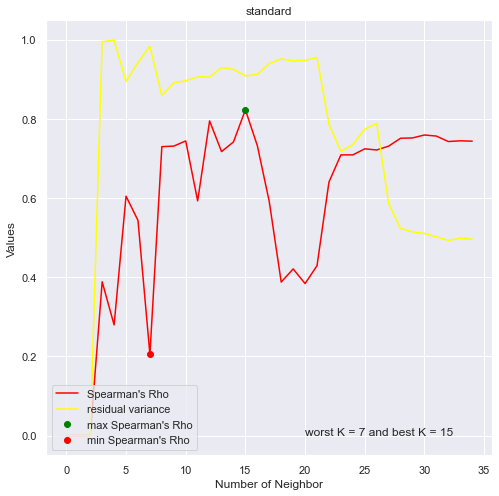

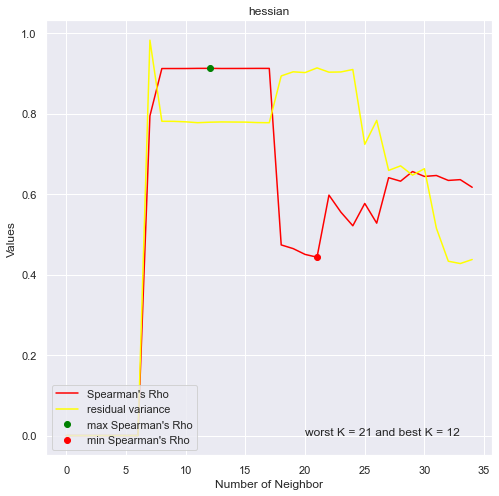

In [123]:
# the swiss roll
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.0)
Best_N_LLE,Worst_N_LLE,_,_ = num_neigh(Dataset_swissroll,2, "standard")
Best_N_HLLE,Worst_N_HLLE,_,_ = num_neigh(Dataset_swissroll,2, "hessian")
#Best_class_N_LLE,Worst_class_N_LLE = num_neigh_ClassifR(Dataset_swissroll,color_three,2, "standard",20,plot="ON")


Best projection LLE
Done. Reconstruction error: 1.09653e-07
Number of neighbor: 10
worst projection LLE 
Done. Reconstruction error: -3.66419e-17
Number of neighbor: 4


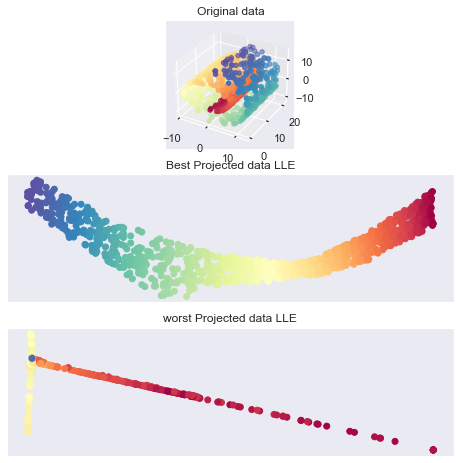

In [79]:
# LLE 

print("Best projection LLE")
X_B_LLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE)
print("worst projection LLE ")
X_W_LLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_LLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE[:, 0], X_B_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_LLE[:, 0], X_W_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE')
plt.show()

Best projection HLLE
Done. Reconstruction error: 3.34363e-06
Number of neighbor: 11
worst projection HLLE
Done. Reconstruction error: 0.00380999
Number of neighbor: 22


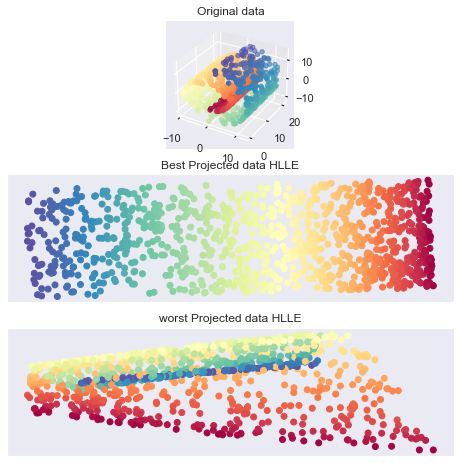

In [80]:
# HLLE 

print("Best projection HLLE")
X_B_HLLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE)
print("worst projection HLLE" )
X_W_HLLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_HLLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_HLLE[:, 0], X_B_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_HLLE[:, 0], X_W_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE')
plt.show()

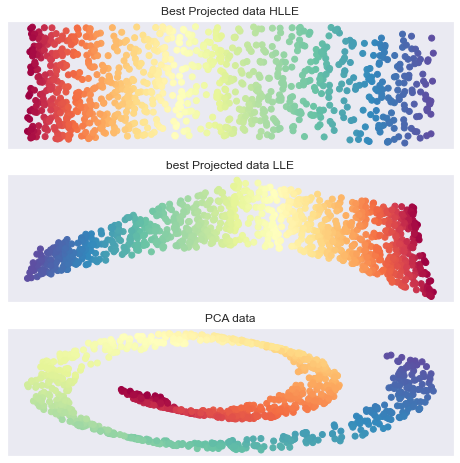

In [26]:

# LLE HLLE and PCA 


pca = PCA(n_components=2)
X_PCA = pca.fit_transform(Dataset_swissroll)

fig = plt.figure(figsize=(8, 8))


ax = fig.add_subplot(311)
ax.scatter(X_B_HLLE[:, 0], X_B_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE[:, 0], X_B_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('PCA data')
plt.show()


## Toy data with noise

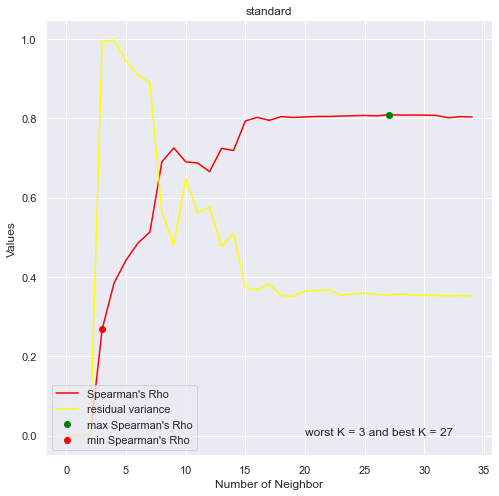

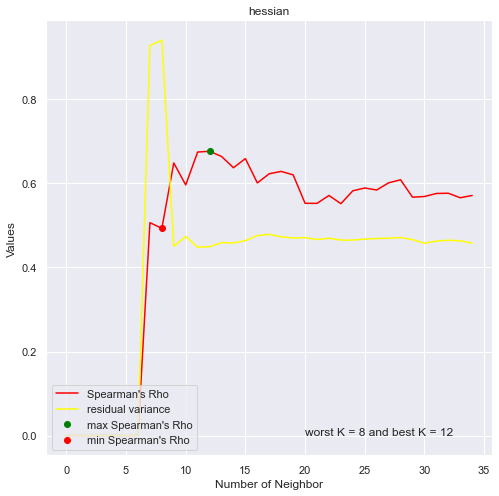

In [35]:
# the swiss roll
Dataset_swissroll_noisy, color = datasets.make_swiss_roll(n_samples=1000,noise = 1)
Best_N_LLE_noisy,Worst_N_LLE_noisy,_,_ = num_neigh(Dataset_swissroll_noisy,2, "standard")
Best_N_HLLE_noisy,Worst_N_HLLE_noisy,_,_ = num_neigh(Dataset_swissroll_noisy,2, "hessian")
#avec le bruit la hessian marche pas parfois, du coup faut juste reload

Best projection LLE
Done. Reconstruction error: 1.04341e-06
Number of neighbor: 27
worst projection LLE 
Done. Reconstruction error: 3.89014e-17
Number of neighbor: 3


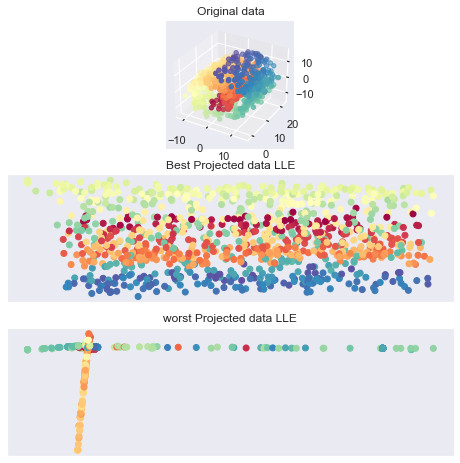

In [36]:
# LLE 

print("Best projection LLE")
X_B_LLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Best_N_LLE_noisy,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE_noisy)
print("worst projection LLE ")
X_W_LLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Worst_N_LLE_noisy,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_LLE_noisy)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll_noisy[:, 0], Dataset_swissroll_noisy[:, 1], Dataset_swissroll_noisy[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE_noisy[:, 0], X_B_LLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_LLE_noisy[:, 0], X_W_LLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE')
plt.show()

Best projection HLLE
Done. Reconstruction error: 0.0139245
Number of neighbor: 12
worst projection HLLE
Done. Reconstruction error: 0.00230072
Number of neighbor: 8


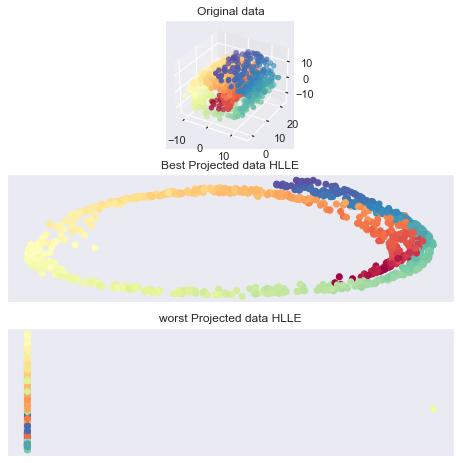

In [37]:
# HLLE 

print("Best projection HLLE")
X_B_HLLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Best_N_HLLE_noisy,n_components=2,method = "hessian", eigen_solver='dense')
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE_noisy)
print("worst projection HLLE" )
X_W_HLLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Worst_N_HLLE_noisy,n_components=2,method = "hessian", eigen_solver='dense')
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_HLLE_noisy)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll_noisy[:, 0], Dataset_swissroll_noisy[:, 1], Dataset_swissroll_noisy[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_HLLE_noisy[:, 0], X_B_HLLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_HLLE_noisy[:, 0], X_W_HLLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE')
plt.show()

si noisy LLE marche pas, mais HLLE oui!

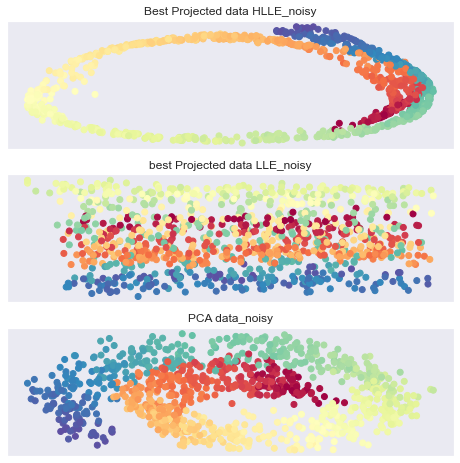

In [38]:

# LLE HLLE and PCA 



pca = PCA(n_components=2)
X_PCA_noisy = pca.fit_transform(Dataset_swissroll_noisy)

fig = plt.figure(figsize=(8, 8))


ax = fig.add_subplot(311)
ax.scatter(X_B_HLLE_noisy[:, 0], X_B_HLLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE_noisy')

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE_noisy[:, 0], X_B_LLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('best Projected data LLE_noisy')

ax = fig.add_subplot(313)
ax.scatter(X_PCA_noisy[:, 0], X_PCA_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('PCA data_noisy')
plt.show()

## Various number of datapoint without noise

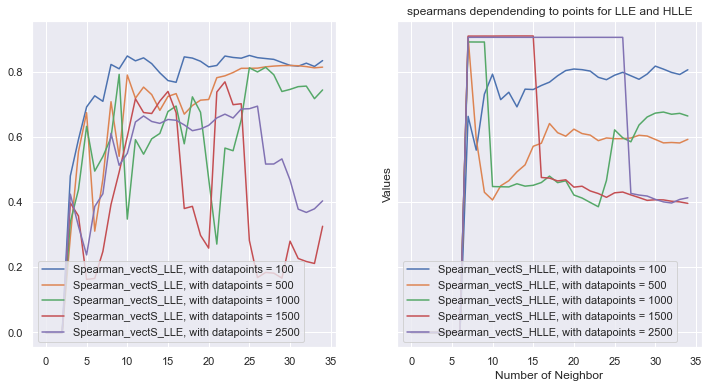

In [4]:
# the swiss roll

Vect_point = [100,500,1000,1500,2500]

Spearman_vectS_LLE = []
Residual_vectS_LLE = []
Spearman_vectS_HLLE = []
Residual_vectS_HLLE = []
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6), sharey=True)
plt.title( "spearmans dependending to points for LLE and HLLE")
plt.xlabel("Number of Neighbor")
plt.ylabel("Values")


for i in Vect_point:
    Dataset_swissroll_point, color = datasets.make_swiss_roll(n_samples=i,noise = 0.0)
    _,_,Residual_vectS_LLE,Spearman_vectS_LLE = num_neigh(Dataset_swissroll_point,2, "standard","OFF")
    _,_,Residual_vectS_HLLE,Spearman_vectS_HLLE = num_neigh(Dataset_swissroll_point,2, "hessian","OFF")

    ax1.plot (Spearman_vectS_LLE,label="Spearman_vectS_LLE, with datapoints = "+ str(i))
    ax2.plot (Spearman_vectS_HLLE,label="Spearman_vectS_HLLE, with datapoints = "+ str(i))

ax1.legend(loc ="lower left")
ax2.legend(loc ="lower left")
plt.show()


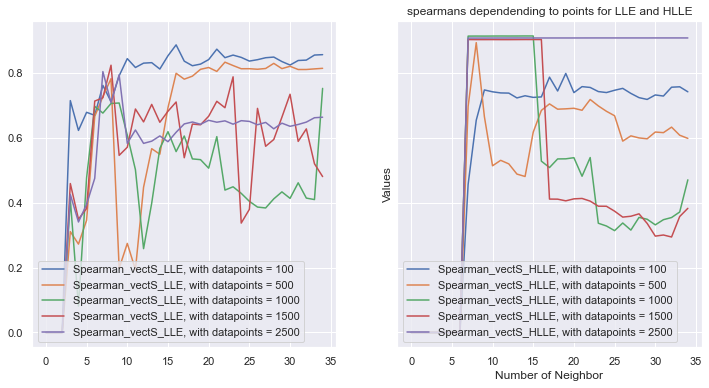

In [39]:
# the swiss roll

Vect_point = [100,500,1000,1500,2500]

MaxLLE_Vect = []
MaxHLLE_Vect = []
Dataset_swissroll_point = []
HLLE_VECT = []
LLE_VECT =[] 
color_Vect=[]
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6), sharey=True)
plt.title( "spearmans dependending to points for LLE and HLLE")
plt.xlabel("Number of Neighbor")
plt.ylabel("Values")

for i in Vect_point:
    Dataset, color= datasets.make_swiss_roll(n_samples=i,noise = 0.0)
    color_Vect.append(color)
    Dataset_swissroll_point.append(Dataset)
    nmaxlle,_,Residual_vectS_LLE,Spearman_vectS_LLE = num_neigh(Dataset,2, "standard","OFF")
    nmaxhlle,_,Residual_vectS_HLLE,Spearman_vectS_HLLE = num_neigh(Dataset,2, "hessian","OFF")
    MaxLLE_Vect.append(nmaxlle)
    MaxHLLE_Vect.append(nmaxhlle)
    XHLLE, err = manifold.locally_linear_embedding(Dataset, n_neighbors=nmaxhlle,n_components=2,method = "hessian", eigen_solver='dense')
    XLLE, err = manifold.locally_linear_embedding(Dataset, n_neighbors=nmaxlle,n_components=2,method = "standard", eigen_solver='dense')
    HLLE_VECT.append(XHLLE)
    LLE_VECT.append(XLLE)
           
    ax1.plot (Spearman_vectS_LLE,label="Spearman_vectS_LLE, with datapoints = "+ str(i))
    ax2.plot (Spearman_vectS_HLLE,label="Spearman_vectS_HLLE, with datapoints = "+ str(i))

ax1.legend(loc ="lower left")
ax2.legend(loc ="lower left")
plt.show()

    


Best projection LLE for different size of data


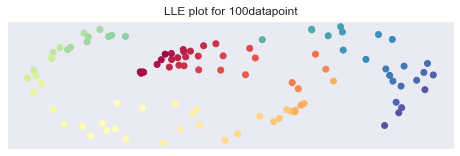

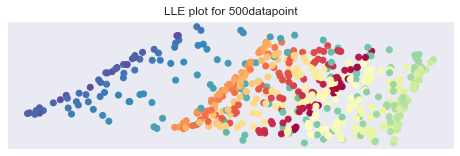

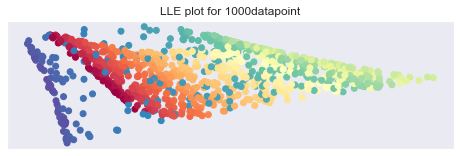

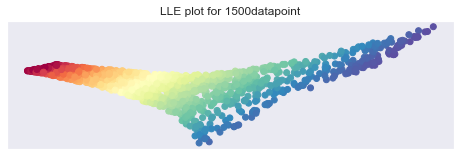

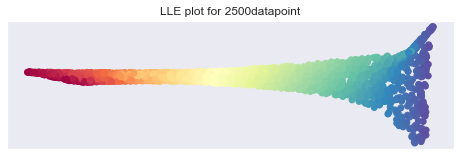

In [50]:
print("Best projection LLE for different size of data")
j = 0
for i in Vect_point:
    name = "LLE plot for "+ str(i)+ "datapoint"
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(311)
    ax.scatter(LLE_VECT[j][:, 0], LLE_VECT[j][:, 1], c=color_Vect[j], cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.xticks([]), plt.yticks([])
    plt.title(name)
    j = j+1



Best projection HLLE for different size of data


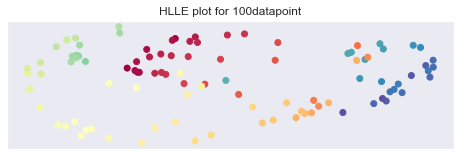

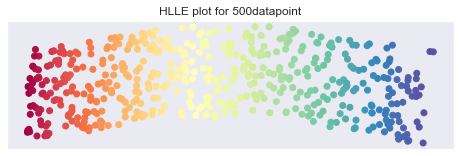

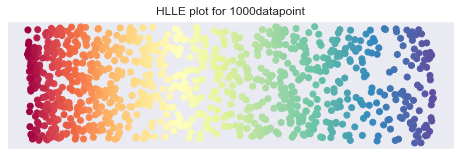

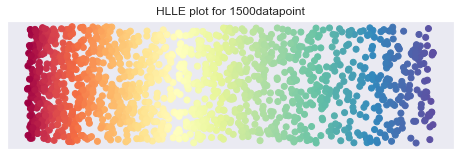

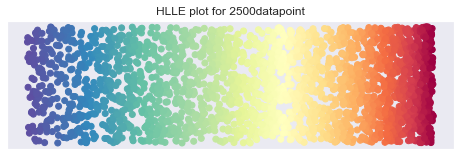

In [51]:
print("Best projection HLLE for different size of data")
j = 0
for i in Vect_point:
    name = "HLLE plot for "+ str(i)+ "datapoint"
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(311)
    ax.scatter(HLLE_VECT[j][:, 0], HLLE_VECT[j][:, 1], c=color_Vect[j], cmap=plt.cm.Spectral)
    plt.axis('tight')
    plt.xticks([]), plt.yticks([])
    plt.title(name)
    j = j+1



# OUR dataset

This data set is 1593 piciture of hand writting between 0-9. The image is in black and white and have 256 pixel each.

In [52]:
# reading csv files
data =  pd.read_csv('Data/semeion.data',header=None, sep=" ")
data = data.drop(columns=[266])
# 256 first columns is pixel and the last 10 is to say which number is it.
# 1593 data
data.shape
#names = ["zero_slow","zero_fast","one_slow","one_fast","two_slow","two_fast","three_slow","three_fast","four_slow","four_fast","five_slow","five_fast","six_slow","six_fast","seven_slow","seven_fast","eight_slow","eight_fast","nine_slow","nine_fast"]
names = ["zero","one","two","three","four","five","six","seven","eight","nine"]

dataf_labels = data.iloc[0:, 256:].astype(int)
dataf_images = data.iloc[0:, :256]

# put the data label in one dim
dataf_labels_oneD= [0]*1593
for i in range(10):
    for j in range (1593):
        if dataf_labels[i+256][j] == 1:
            dataf_labels_oneD[j] = i

Lab = pd.DataFrame(data = dataf_labels_oneD, columns = ['Label'])

In [53]:
# keep just the pixel for visualization

images = data.truncate(before="0", after="255", axis="columns")
image =[0]*1593
image_reshape =[0]*1593
for i in range (0,1592):
    image[i] = np.array(images.iloc[i])
    image_reshape[i] = np.reshape(image[i],(16,16))

In [54]:
data

0    1    2    3    4    5    6    7    8    9    ...  256  257  258  \
0     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0   
1     0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...    1    0    0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0   
3     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1588  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...    0    0    0   
1589  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...    0    0    0   
1590  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...    0    0    0   
1591  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...    0    0    0   
1592  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    0    0    0   

      259  260  261  262  263  264  265  
0       0    0    0    0    0    0    0  
1       0    0    0    0    0    0    0  
2       0    0    0    0    0    0    0  
3       0    0    0    0    0    0    0  
4       0    0    0    0    0    0    0  
...   ...  ...  ...  ...  ...  ...  ...  
1588    0    0    0    0    0    0    1  
1589    0    0    0    0    0    0    1  
1590    0    0    0    0    0    0    1  
1591    0    0    0    0    0    0    1  
1592    0    0    0    0    0    0    1  

[1593 rows x 266 columns]

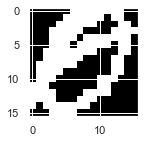

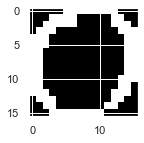

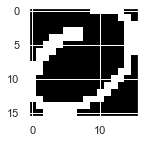

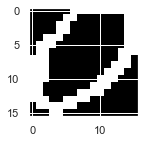

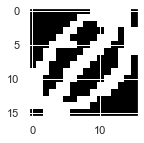

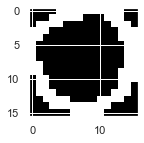

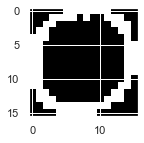

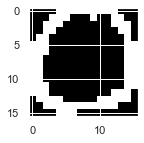

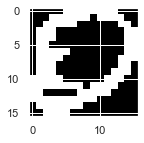

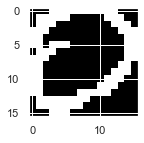

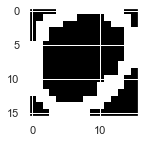

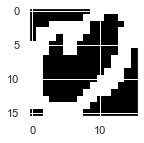

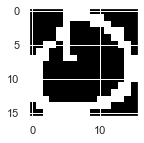

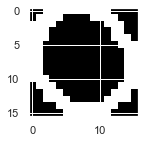

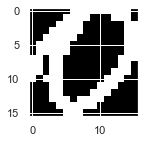

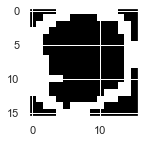

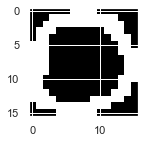

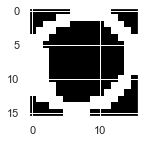

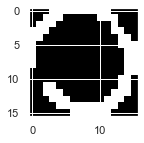

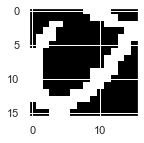

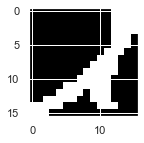

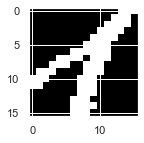

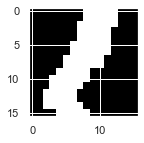

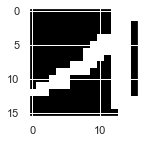

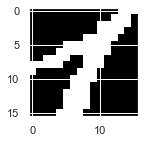

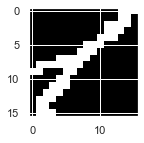

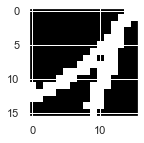

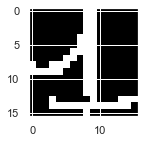

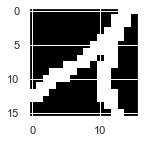

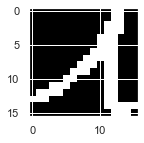

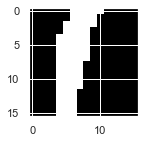

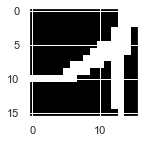

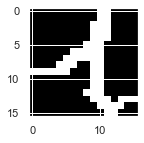

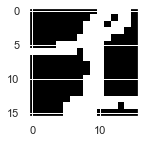

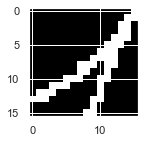

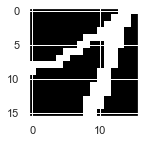

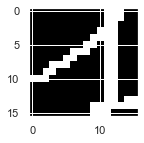

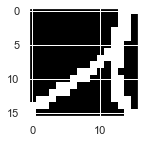

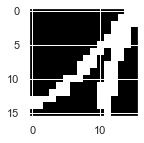

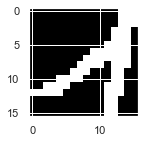

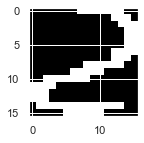

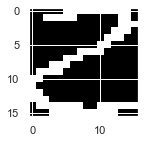

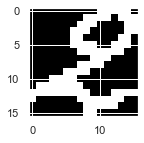

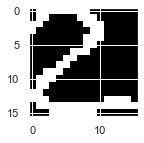

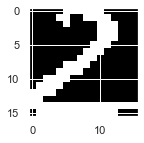

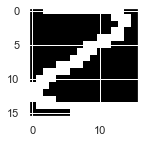

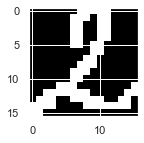

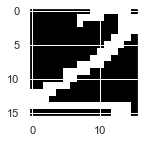

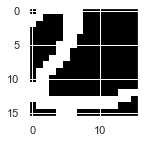

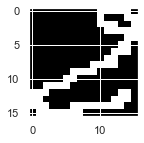

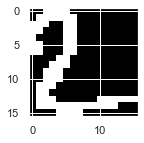

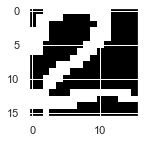

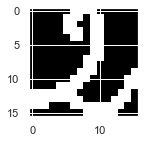

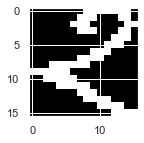

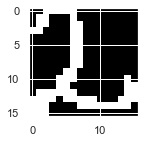

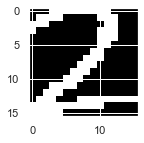

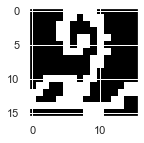

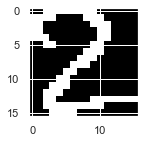

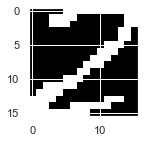

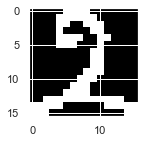

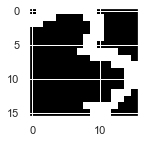

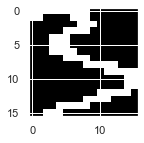

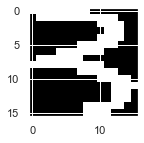

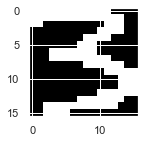

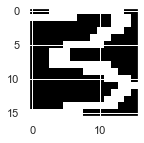

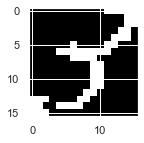

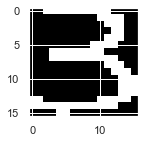

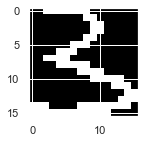

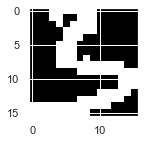

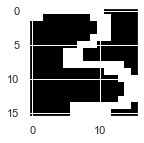

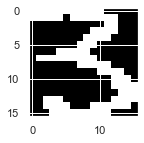

KeyboardInterrupt: 

<Figure size 144x144 with 0 Axes>

In [59]:
#plot each image
for i in range (0,1592):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(image_reshape[i], cmap=plt.cm.gray)
    plt.show()

3
2
4
2
5
2
6
2
7
2
8
2
9
2
10
2
11
2
12
2
13
2
14
2
15
2
16
2
17
2
18
2
19
2
20
2
21
2
22
2
23
2
24
2
25
2
26
2
27
2
28
2
29
2
30
2
31
2
32
2
33
2
34
2


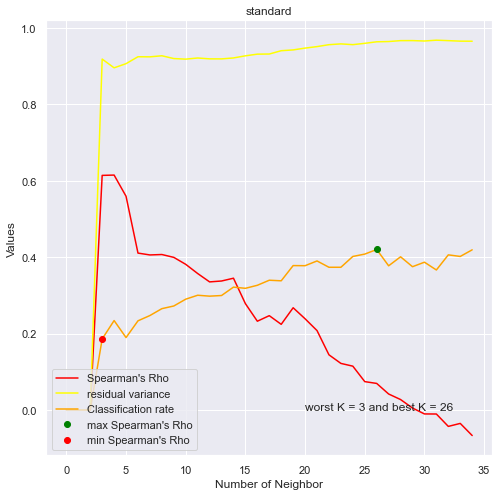

In [107]:
Data = dataf_images
Label = Lab
meth = "standard"
plot = "ON"
Kmx = 20
SP_Rho_vect       = []
Residual_var_vect = []
classif_vect      = []
N_Neigh_Max       = 35
NCOMP             = 2


# We split the data into train and test to evaluate the classification 
Split = 0.3
X_tr, X_ts, Label_tr, Label_ts = train_test_split(Data, Label, test_size=Split)

# Here we normalize the data (Not neceesary on our case because data is black and white pixel)
X_tr_St     = StandardScaler().fit_transform(X_tr)
X_ts_St     = StandardScaler().fit_transform(X_ts)
X_tr_Norm   = Normalizer().fit_transform(X_tr_St)
X_ts_Norm   = Normalizer().fit_transform(X_ts_St)

if meth == "standard":
    nmin   = NCOMP+1
    Vect_N = np.arange(nmin,N_Neigh_Max,1)
if meth == "hessian":
    nmin   = round(NCOMP*(NCOMP+3)/2)+2
    Vect_N = np.arange( nmin,N_Neigh_Max,1)
Tot_Err     = []
for j in range(nmin):
    SP_Rho_vect.append(0)
    Residual_var_vect.append(0)
    classif_vect.append(0)

for i in Vect_N:
    print(i)
    print(NCOMP)
    clf = manifold.LocallyLinearEmbedding(n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
    X_tr_transfo  = clf.fit_transform(X_tr_Norm)
    X_ts_transfo  = clf.transform(X_ts_Norm)
    kopt_transfo = knn(X_tr_transfo,X_ts_transfo,Label_tr,Label_ts, Kmx)
    classif_vect.append(classifR(X_tr_Norm,X_ts_Norm,X_tr_transfo,X_ts_transfo,Label_tr,Label_ts,kopt_transfo))
    Tot_Err.append(err)
    SP_Rho_vect.append(SpearsmansRho(X_tr_transfo,X_tr_Norm))
    Residual_var_vect.append(res_var(X_tr_transfo,X_tr_Norm))

Tot_err = np.array(Tot_Err)
maxval_SP =max(classif_vect[nmin:]) 
indicemax_SP = classif_vect.index(maxval_SP)
minval_SP =min(classif_vect[nmin:]) 
indicemin_SP = classif_vect.index(minval_SP)


if plot == "ON":
    plt.figure(meth,figsize=(8, 8))
    plt.title( meth)
    plt.xlabel("Number of Neighbor")
    plt.ylabel("Values")
    plt.plot (SP_Rho_vect,color ="red",label="Spearman's Rho")
    plt.plot (Residual_var_vect,color ="yellow",label="residual variance")
    plt.plot(classif_vect,color ="orange",label="Classification rate")

    plt.plot (indicemax_SP,maxval_SP,"go",color ="green",label="max Classification rate")
    plt.plot (indicemin_SP,minval_SP,"go",color ="red",label="min Classification rate")

    plt.legend(loc ="lower left")
    plt.text(20,0,"worst K = "+ str(indicemin_SP) +" and best K = " + str(indicemax_SP))


In [103]:
np.info(X_ts_transfo)

class:  ndarray
shape:  (478, 2)
strides:  (16, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f8caa731800
byteorder:  little
byteswap:  False
type: float64


In [55]:
# Hyperparamters
# K       : number of neighbors
# d       : dimensions reductivity

K    = 22
d    = 2
Kmax = 20



In [56]:
# We split the data into train and test to evaluate the classification 
Split = 0.3
X_train, X_test, Label_train, Label_test = train_test_split(dataf_images, Lab, test_size=Split)



In [57]:
# Here we normalize the data (Not neceesary on our case because data is black and white pixel)
X_train_St    = StandardScaler().fit_transform(X_train)
X_test_St     = StandardScaler().fit_transform(X_test)
X_train_Norm  = Normalizer().fit_transform(X_train_St)
X_test_Norm   = Normalizer().fit_transform(X_test_St)

## LLE for visuability

Here we focus our study on the visuability. We define d = 2 and we try to keep the best topology. Thus we use spearman's Rho.

3
classification rate for LLE is 0.3579676674364896


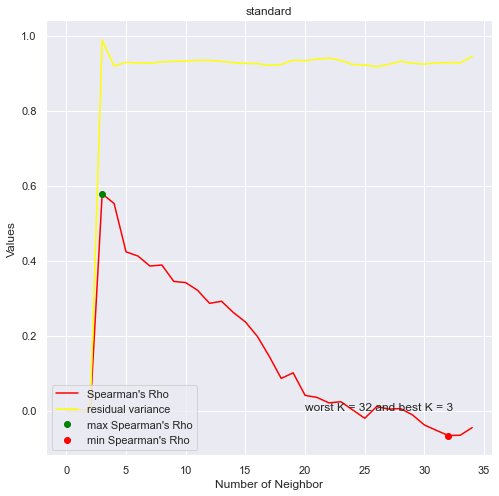

In [58]:
# 2 Dimensions reduction

# LLE
Best_N_LLE,Worst_N_LLE,_,_ = num_neigh(X_train_Norm,2, "standard")
clf_LLE = manifold.LocallyLinearEmbedding(n_neighbors=Best_N_LLE, n_components=d, method ='standard')

print(Best_N_LLE)
X_train_LLE = clf_LLE.fit_transform(X_train_Norm)
X_test_LLE  = clf_LLE.transform(X_test_Norm)


# conver to panda data frame with index and comportement
LLE_Df_feature_train = pd.DataFrame(data = X_train_LLE, columns = ['LLE 1', 'LLE 2'])
LLE_Df_train = pd.concat([LLE_Df_feature_train, Label_train], axis = 1)

# Test accuracy for clasification

kopt_LLE = knn(X_train_LLE,X_test_LLE,Label_train,Label_test, Kmax)
r_LLE = classifR(X_train_Norm,X_test_Norm,X_train_LLE,X_test_LLE,Label_train,Label_test,kopt_LLE)
print("classification rate for LLE is" , r_LLE)


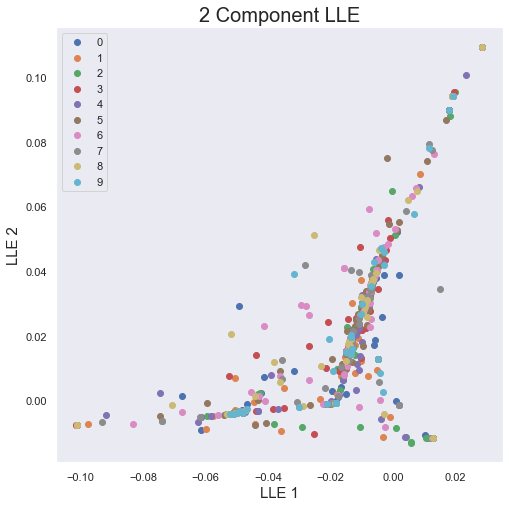

In [59]:
#plot for LLe
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LLE 1', fontsize = 15)
ax.set_ylabel('LLE 2', fontsize = 15)
ax.set_title('2 Component LLE', fontsize = 20)

targets = [0,1,2,3,4,5,6,7,8,9]
colors = ['yellow', 'orange', 'red',"purple","blue","turquoise","green","braun","grey","black"]
for target, color in zip(targets,colors):
    indicesToKeep = LLE_Df_train['Label'] == target
    ax.scatter(LLE_Df_train.loc[indicesToKeep, 'LLE 1'], LLE_Df_train.loc[indicesToKeep, 'LLE 2'])

ax.legend(targets)
ax.grid()

10
classification ratefor HLLE is 0.7652582159624414


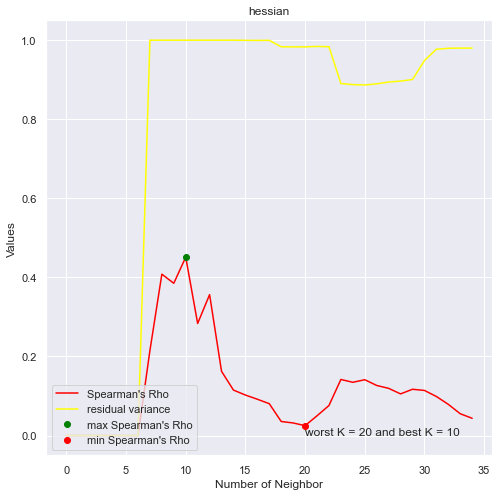

In [60]:
# 2 Dimensions reduction

# HLLE
Best_N_HLLE,Worst_N_HLLE,_,_ = num_neigh(X_train_Norm,d, "hessian")
clf_HLLE = manifold.LocallyLinearEmbedding(n_neighbors=Best_N_HLLE, n_components=d, method ='hessian',eigen_solver="dense")

print(Best_N_HLLE)
X_train_HLLE = clf_HLLE.fit_transform(X_train_Norm)
X_test_HLLE  = clf_HLLE.transform(X_test_Norm)


# conver to panda data frame with index and comportement
HLLE_Df_feature_train = pd.DataFrame(data = X_train_HLLE, columns = ['HLLE 1', 'HLLE 2'])
HLLE_Df_train = pd.concat([HLLE_Df_feature_train, Lab], axis = 1)

kopt_HLLE = knn(X_train_HLLE,X_test_HLLE,Label_train,Label_test, Kmax)

r_HLLE = classifR(X_train_Norm,X_test_Norm,X_train_HLLE,X_test_HLLE,Label_train,Label_test,kopt_HLLE)
print("classification ratefor HLLE is" , r_HLLE)


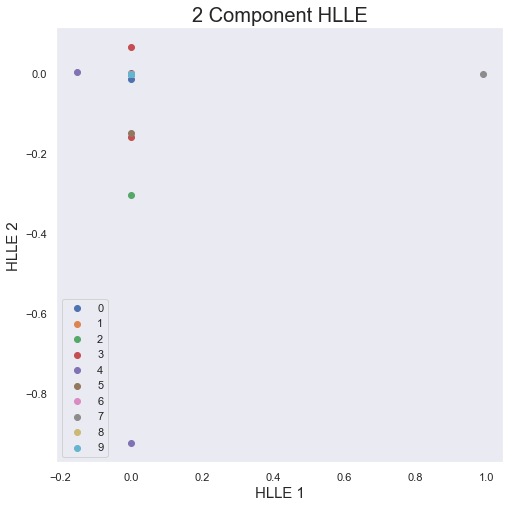

In [61]:
#plot for HLLe
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('HLLE 1', fontsize = 15)
ax.set_ylabel('HLLE 2', fontsize = 15)
ax.set_title('2 Component HLLE', fontsize = 20)

targets = [0,1,2,3,4,5,6,7,8,9]
colors = ['yellow', 'orange', 'red',"purple","blue","turquoise","green","braun","grey","black"]
for target, color in zip(targets,colors):
    indicesToKeep = HLLE_Df_train['Label'] == target
    ax.scatter(HLLE_Df_train.loc[indicesToKeep, 'HLLE 1'], HLLE_Df_train.loc[indicesToKeep, 'HLLE 2'])
ax.legend(targets)
ax.grid()

In [62]:
# pca 
pca = PCA(n_components=d)
X_train_PCA =pca.fit_transform(X_train_Norm)
X_test_PCA  = clf_HLLE.transform(X_test_Norm)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

principalDf = pd.DataFrame(data = X_train_PCA, columns = ['PrComp 1', 'PrComp 2',]) 
pca_Df = pd.concat([principalDf, Lab], axis = 1)

# PCA
kopt_PCA = knn(X_train_PCA,X_test_PCA,Label_train,Label_test, Kmax)
r_pca = classifR(X_train_Norm,X_test_Norm,X_train_PCA,X_test_PCA,Label_train,Label_test,kopt_PCA)

print("classification rate for pca  is",r_pca)

[0.07764634 0.06623897]
[9.30432865 8.59372242]
classification rate for pca  is 0.8726851851851852


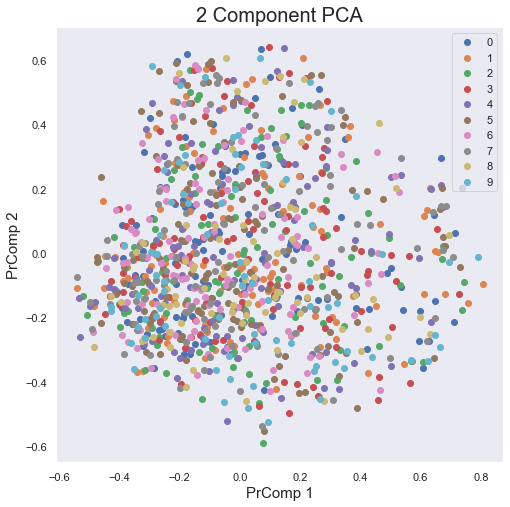

In [63]:
#plot for pca
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PrComp 1', fontsize = 15)
ax.set_ylabel('PrComp 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1,2,3,4,5,6,7,8,9]
colors = ['yellow', 'orange', 'red',"purple","blue","turquoise","green","braun","grey","black"]
for target, color in zip(targets,colors):
    indicesToKeep = pca_Df['Label'] == target
    ax.scatter(pca_Df.loc[indicesToKeep, 'PrComp 1']
               , pca_Df.loc[indicesToKeep, 'PrComp 2'])

ax.legend(targets)
ax.grid()

Let's try in 3d( Just for le kif mon pote)

In [69]:
# 3 Dimensions reduction
Dim =3
# LLE
Best_N_LLE_3d,Worst_N_LLE_3d,_,_ = num_neigh(X_train_Norm,Dim, "standard","OFF")
clf_LLE_3d = manifold.LocallyLinearEmbedding(n_neighbors=Best_N_LLE_3d, n_components=Dim, method ='standard',eigen_solver="dense")

print(Best_N_LLE)
X_train_LLE_3d = clf_LLE_3d.fit_transform(X_train_Norm)
X_test_LLE_3d  = clf_LLE_3d.transform(X_test_Norm)

kopt_LLE_3d = knn(X_train_LLE_3d,X_test_LLE_3d,Label_train,Label_test, Kmax)

r_LLE_3d = classifR(X_train_Norm,X_test_Norm,X_train_LLE_3d,X_test_LLE_3d,Label_train,Label_test,kopt_LLE_3d)
print("classification ratefor LLE is" , r_LLE_3d)



# convert to panda data frame with index and comportement
LLE_Df_feature_train_3d = pd.DataFrame(data = X_train_LLE_3d, columns = ['LLE 1', 'LLE 2',"LLE 3"])
LLE_Df_train_3d = pd.concat([LLE_Df_feature_train_3d, Lab], axis = 1)


3
classification ratefor HLLE is 0.1728110599078341


In [70]:
# 3 Dimensions reduction
Dim =3
# HLLE
Best_N_HLLE_3d,Worst_N_HLLE_3d,_,_ = num_neigh(X_train_Norm,Dim, "hessian","OFF")
clf_HLLE_3d = manifold.LocallyLinearEmbedding(n_neighbors=Best_N_HLLE_3d, n_components=Dim, method ='hessian',eigen_solver="dense")

print(Best_N_HLLE)
X_train_HLLE_3d = clf_HLLE_3d.fit_transform(X_train_Norm)
X_test_HLLE_3d  = clf_HLLE_3d.transform(X_test_Norm)

kopt_HLLE_3d = knn(X_train_HLLE_3d,X_test_HLLE_3d,Label_train,Label_test, Kmax)

r_HLLE_3d = classifR(X_train_Norm,X_test_Norm,X_train_HLLE_3d,X_test_HLLE_3d,Label_train,Label_test,kopt_HLLE_3d)
print("classification ratefor HLLE is" , r_HLLE_3d)

# convert to panda data frame with index and comportement
HLLE_Df_feature_train_3d = pd.DataFrame(data = X_train_HLLE_3d, columns = ['HLLE 1', 'HLLE 2',"HLLE 3"])
HLLE_Df_train_3d = pd.concat([HLLE_Df_feature_train_3d, Lab], axis = 1)


10
classification ratefor HLLE is 0.723404255319149


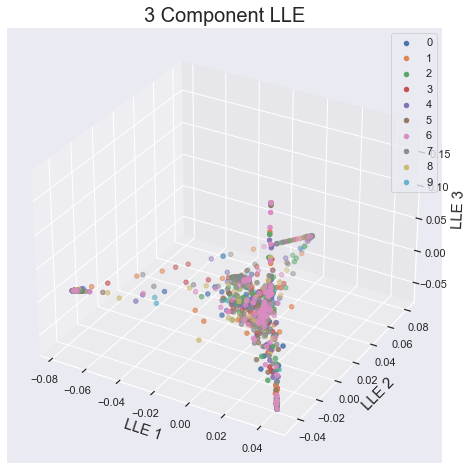

In [71]:
# plot 3d LLE
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('LLE 1', fontsize = 15)
ax.set_ylabel('LLE 2', fontsize = 15)
ax.set_zlabel('LLE 3', fontsize = 15)
ax.set_title('3 Component LLE', fontsize = 20)

targets = [0,1,2,3,4,5,6,7,8,9]
colors = ['yellow', 'orange', 'red',"purple","blue","turquoise","green","braun","grey","black"]
for target, color in zip(targets,colors):
    indicesToKeep = LLE_Df_train_3d['Label'] == target
    ax.scatter(LLE_Df_train_3d.loc[indicesToKeep, 'LLE 1']
               , LLE_Df_train_3d.loc[indicesToKeep, 'LLE 2'], LLE_Df_train_3d.loc[indicesToKeep, 'LLE 3'])

ax.legend(targets)
ax.grid()

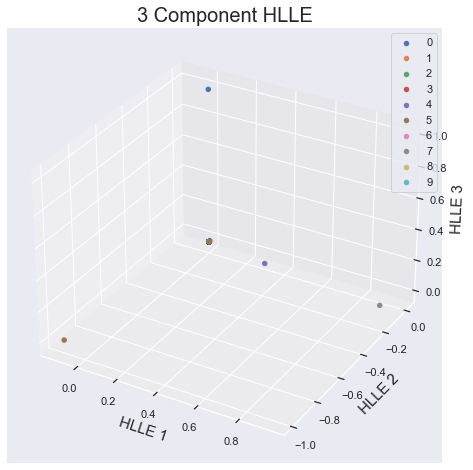

In [72]:
# plot 3d HLLE
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('HLLE 1', fontsize = 15)
ax.set_ylabel('HLLE 2', fontsize = 15)
ax.set_zlabel('HLLE 3', fontsize = 15)
ax.set_title('3 Component HLLE', fontsize = 20)

targets = [0,1,2,3,4,5,6,7,8,9]
colors = ['yellow', 'orange', 'red',"purple","blue","turquoise","green","braun","grey","black"]
for target, color in zip(targets,colors):
    indicesToKeep = HLLE_Df_train_3d['Label'] == target
    ax.scatter(HLLE_Df_train_3d.loc[indicesToKeep, 'HLLE 1']
               , HLLE_Df_train_3d.loc[indicesToKeep, 'HLLE 2'], HLLE_Df_train_3d.loc[indicesToKeep, 'HLLE 3'])

ax.legend(targets)
ax.grid()

Here we will comput the see the effect of LLE and HLLE in function of the dimensionnality reduction.
Thus ,for each dim, we will find the best number of neighborr in function to have the best classification rate, and his classification rate and spearmans'rho.

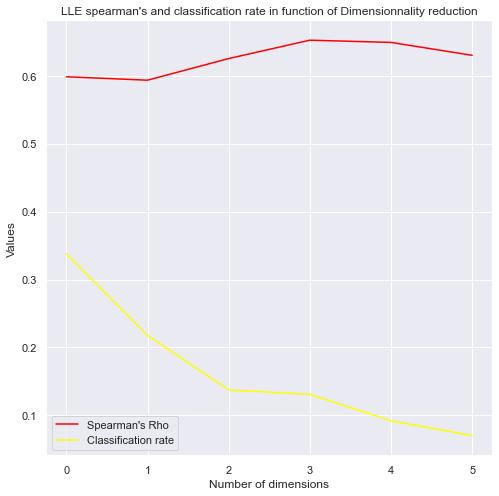

In [43]:
#find the best dim for reduction for LLE
dmax = 6
spearm_LLE = []
classif_LLE = []

for d in np.arange(1,dmax+1,1):

    # find best number of neighbor
    Best_N_LLE_d,Worst_N_LLE_d,_,_ = num_neigh(X_train_Norm,int(d), "standard","OFF")

    #compute HLLE with best number of neighbor
    clf_LLE_d = manifold.LocallyLinearEmbedding(n_neighbors=Best_N_LLE_d, n_components=d, method ='standard',eigen_solver="dense")

    X_train_LLE_d = clf_LLE_d.fit_transform(X_train_Norm)
    X_test_LLE_d  = clf_LLE_d.transform(X_test_Norm)

    # value for classification rate
    kopt_LLE_d = knn(X_train_LLE_d,X_test_LLE_d,Label_train,Label_test, Kmax)
    r_LLE_d = classifR(X_train_Norm,X_test_Norm,X_train_LLE_d,X_test_LLE_d,Label_train,Label_test,kopt_LLE_d)
    classif_LLE.append(r_LLE_d)

    # spearman rho
    spearm_LLE.append(SpearsmansRho(X_train_Norm,X_train_LLE_d))

plt.figure("standard",figsize=(8, 8))
plt.title( "LLE spearman's and classification rate in function of Dimensionnality reduction")
plt.xlabel("Number of dimensions")
plt.ylabel("Values")
plt.plot (spearm_LLE,color ="red",label="Spearman's Rho")
plt.plot (classif_LLE,color ="blue",label="Classification rate")


plt.legend(loc ="lower left")


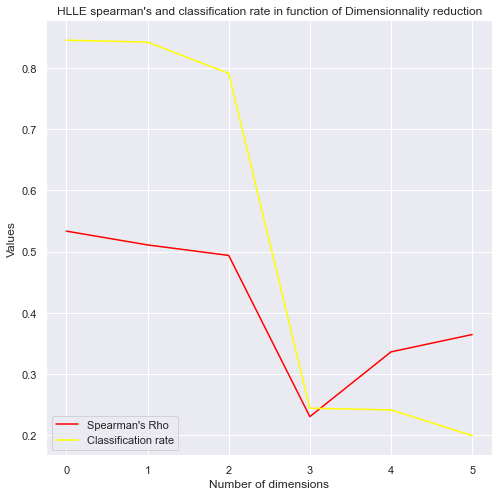

In [44]:
#find the best dim for reduction for HLLE
dmax = 6
spearm_HLLE = []
classif_HLLE = []

for d in np.arange(1,dmax+1,1):

    # find best number of neighbor
    Best_N_HLLE_d,Worst_N_HLLE_d,_,_ = num_neigh(X_train_Norm,int(d), "hessian","OFF")

    #compute HLLE with best number of neighbor
    clf_HLLE_d = manifold.LocallyLinearEmbedding(n_neighbors=Best_N_HLLE_d, n_components=d, method ='hessian',eigen_solver="dense")

    X_train_HLLE_d = clf_HLLE_d.fit_transform(X_train_Norm)
    X_test_HLLE_d  = clf_HLLE_d.transform(X_test_Norm)

    # value for classification rate
    kopt_HLLE_d = knn(X_train_HLLE_d,X_test_HLLE_d,Label_train,Label_test, Kmax)
    r_HLLE_d = classifR(X_train_Norm,X_test_Norm,X_train_HLLE_d,X_test_HLLE_d,Label_train,Label_test,kopt_HLLE_d)
    classif_HLLE.append(r_HLLE_d)

    # spearman rho
    spearm_HLLE.append(SpearsmansRho(X_train_Norm,X_train_HLLE_d))

plt.figure("hessian",figsize=(8, 8))
plt.title( "HLLE spearman's and classification rate in function of Dimensionnality reduction")
plt.xlabel("Number of dimensions")
plt.ylabel("Values")
plt.plot (spearm_HLLE,color ="red",label="Spearman's Rho")
plt.plot (classif_HLLE,color ="blue",label="Classification rate")


plt.legend(loc ="lower left")


In [ ]:
 noise_type == "sp":
row,col = image.shape
s_vs_p = 0.5
amount = 0.10
out = np.copy(image)
#salt
num_salt = np.ceil(amount * image.size * s_vs_p)
coords = [np.random.randint(0, i - 1, int(num_salt))
        for i in image.shape]
out[coords] = 1
#pepper
num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
coords = [np.random.randint(0, i - 1, int(num_pepper))
        for i in image.shape]
out[coords] = 0
return out